In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# import keras.backend as K
# K.set_image_data_format(‘channels_last’)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [ ]:
!wget -cq http://opensurfaces.cs.cornell.edu/static/minc/minc-2500.tar.gz

In [ ]:
import tarfile
tar = tarfile.open("minc-2500.tar.gz")
tar.extractall()
tar.close()

In [ ]:
original_images_dir = '/content/minc-2500/images'
sub_dirs = ['metal', 'glass', 'fabric', 'leather', 'paper', 'stone', 'wood', 'plastic', 'water', 'foliage']

In [ ]:
import os
train_dir = '/content/train'
val_dir = '/content/val'
for sub_dir in sub_dirs:
    os.makedirs(train_dir+"/"+sub_dir, exist_ok=True)
for sub_dir in sub_dirs:
    os.makedirs(val_dir+"/"+sub_dir, exist_ok=True)

In [ ]:
import cv2
for sub_dir in sub_dirs:
    cur_folder = original_images_dir+"/"+sub_dir
    for i,filename in enumerate(os.listdir(cur_folder)):
        img = cv2.imread(cur_folder+"/"+filename)
        if i>1999:
            cv2.imwrite(val_dir+"/"+sub_dir+"/"+filename, img)
        else:
            cv2.imwrite(train_dir+"/"+sub_dir+"/"+filename, img)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255 and image augmentation has also been used to reduce variance in our training
train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      rotation_range=20,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 140 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/train/',  # This is the source directory for training images
        target_size=(150, 150),
        batch_size=256,
        class_mode='categorical')

# Flow validation images in batches of 30 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/val/',  # This is the source directory for validation images
        target_size=(150, 150),  
        batch_size=256,
        class_mode='categorical')

Found 20000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [ ]:
import os
#tf.keras.backend.clear_session()
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.layers import Dropout

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras import regularizers

In [ ]:
from keras.layers import Dropout

In [ ]:
def AlexNet(input_shape):
    
  X_input = Input(input_shape)
  x_dropout = Dropout(0.3)(X_input) 
  X = Conv2D(96,(11,11),strides = 4,name="conv0", kernel_regularizer=regularizers.l2(0.0005))(X_input)
  X = BatchNormalization(axis = 3 , name = "bn0")(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)

  X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1', kernel_regularizer=regularizers.l2(0.0005))(X)
  X = BatchNormalization(axis = 3 ,name='bn1')(X)
  X = Activation('relu')(X)
  X = Dropout(0.3)(X) 

  X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)

  X = Conv2D(384, (3,3) , padding = 'same' , name='conv2', kernel_regularizer=regularizers.l2(0.0005))(X)
  X = BatchNormalization(axis = 3, name = 'bn2')(X)
  X = Activation('relu')(X)
  X = Dropout(0.3)(X) 

  X = Conv2D(384, (3,3) , padding = 'same' , name='conv3', kernel_regularizer=regularizers.l2(0.0005))(X)
  X = BatchNormalization(axis = 3, name = 'bn3')(X)
  X = Activation('relu')(X)
  X = Dropout(0.3)(X) 

  X = Conv2D(256, (3,3) , padding = 'same' , name='conv4', kernel_regularizer=regularizers.l2(0.0005))(X)
  X = BatchNormalization(axis = 3, name = 'bn4')(X)
  X = Activation('relu')(X)
  X = Dropout(0.3)(X) 

  X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)

  X = Flatten()(X)

  X = Dense(4096, activation = 'relu', name = "fc0")(X)

  X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

  X = Dense(10 ,activation='softmax',name = 'fc2')(X)

  model = Model(inputs = X_input, outputs = X, name='AlexNet')
  return model

In [ ]:
alex = AlexNet(train_generator[0][0].shape[1:])
alex.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 35, 35, 96)        34944     
                                                                 
 bn0 (BatchNormalization)    (None, 35, 35, 96)        384       
                                                                 
 activation (Activation)     (None, 35, 35, 96)        0         
                                                                 
 max0 (MaxPooling2D)         (None, 17, 17, 96)        0         
                                                                 
 conv1 (Conv2D)              (None, 17, 17, 256)       614656    
                                                                 
 bn1 (BatchNormalization)    (None, 17, 17, 256)       1024

In [ ]:
import tensorflow as tf

In [ ]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
alex.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
alex.fit(train_generator, epochs=100, steps_per_epoch=79, validation_data = validation_generator, verbose = 1, validation_steps=20, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/100
79/79 [==============================] - 209s 2s/step - loss: 5.0983 - accuracy: 0.1602 - val_loss: 2.8267 - val_accuracy: 0.2002
Epoch 2/100
79/79 [==============================] - 178s 2s/step - loss: 2.7535 - accuracy: 0.2039 - val_loss: 2.7701 - val_accuracy: 0.2184
Epoch 3/100
79/79 [==============================] - 178s 2s/step - loss: 2.6711 - accuracy: 0.2220 - val_loss: 2.7304 - val_accuracy: 0.1794
Epoch 4/100
79/79 [==============================] - 175s 2s/step - loss: 2.5412 - accuracy: 0.2557 - val_loss: 2.7128 - val_accuracy: 0.1614
Epoch 5/100
79/79 [==============================] - 174s 2s/step - loss: 2.4286 - accuracy: 0.2855 - val_loss: 2.6135 - val_accuracy: 0.2004
Epoch 6/100
79/79 [==============================] - 173s 2s/step - loss: 2.3260 - accuracy: 0.3160 - val_loss: 2.6227 - val_accuracy: 0.1760
Epoch 7/100
79/79 [==============================] - 174s 2s/step - loss: 2.2368 - accuracy: 0.3343 - val_loss: 2.5702 - val_accuracy: 0.1812
Epoch 

In [ ]:
alex.history.history

{'accuracy': [0.16019999980926514,
  0.20389999449253082,
  0.22200000286102295,
  0.2556999921798706,
  0.28554999828338623,
  0.3160499930381775,
  0.33425000309944153,
  0.34975001215934753,
  0.3668000102043152,
  0.3810499906539917,
  0.3894500136375427,
  0.40560001134872437,
  0.4119499921798706,
  0.415800005197525,
  0.42260000109672546,
  0.42750000953674316,
  0.43700000643730164,
  0.4389500021934509,
  0.4405499994754791,
  0.4531500041484833,
  0.4477500021457672,
  0.46369999647140503,
  0.4563499987125397,
  0.45840001106262207,
  0.46825000643730164,
  0.4663499891757965,
  0.4657500088214874,
  0.4783500134944916,
  0.4733000099658966,
  0.48249998688697815,
  0.4797999858856201,
  0.48730000853538513,
  0.48335000872612,
  0.48445001244544983,
  0.4864000082015991,
  0.48945000767707825,
  0.48910000920295715,
  0.49230000376701355,
  0.4985499978065491,
  0.49619999527931213,
  0.49195000529289246,
  0.5023999810218811,
  0.5046499967575073,
  0.501800000667572,
  0

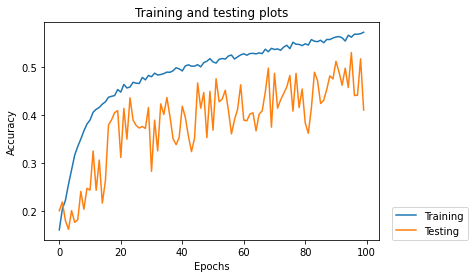

In [ ]:
  # plotting Training and testing accuracy against
plt.plot(alex.history.history['accuracy'])
plt.plot(alex.history.history['val_accuracy'])
plt.title('Training and testing plots')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Testing'], loc=(1.04,0))
plt.show()

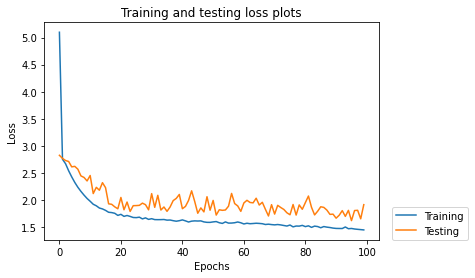

In [ ]:
plt.plot(alex.history.history['loss'])
plt.plot(alex.history.history['val_loss'])
plt.title('Training and testing loss plots')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Testing'], loc=(1.04,0))
plt.show()

In [ ]:
alex.save('AlexNet')

INFO:tensorflow:Assets written to: AlexNet/assets


In [ ]:
alex.save("my_h5_model.h5")